In [ ]:
####MLP algorithm implementation
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  #

# Step 1: Load the data
file_path = "/content/drive/MyDrive/diabetes_012_health_indicators_BRFSS2015.csv"
data = pd.read_csv(file_path)

# Print the column names
print("Dataset Column Names:")
print(data.columns)

# Step 2: Data preprocessing
X = data.drop('Diabetes_012', axis=1).values
y = data['Diabetes_012'].values

# Correcting class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale the data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Convert to PyTorch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Dataset Column Names:
Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Train Loss: 0.7543, Train Accuracy: 63.88%, Validation Loss: 0.6858, Validation Accuracy: 67.23%
Epoch [2/150], Train Loss: 0.6588, Train Accuracy: 68.91%, Validation Loss: 0.6181, Validation Accuracy: 71.28%
Epoch [3/150], Train Loss: 0.6208, Train Accuracy: 71.34%, Validation Loss: 0.5874, Validation Accuracy: 73.18%
Epoch [4/150], Train Loss: 0.5893, Train Accuracy: 73.21%, Validation Loss: 0.5529, Validation Accuracy: 75.22%
Epoch [5/150], Train Loss: 0.5617, Train Accuracy: 74.77%, Validation Loss: 0.5277, Validation Accuracy: 76.65%
Epoch [6/150], Train Loss: 0.5398, Train Accuracy: 75.95%, Validation Loss: 0.5217, Validation Accuracy: 77.31%
Epoch [7/150], Train Loss: 0.5192, Train Accuracy: 77.01%, Validation Loss: 0.4733, Validation Accuracy: 79.44%
Epoch [8/150], Train Loss: 0.5022, Train Accuracy: 77.89%, Validation Loss: 0.4638, Validation Accuracy: 79.81%
Epoch [9/150], Train Loss: 0.4897, Train Accuracy: 78.50%, Validation Loss: 0.4595, Validation Accuracy:

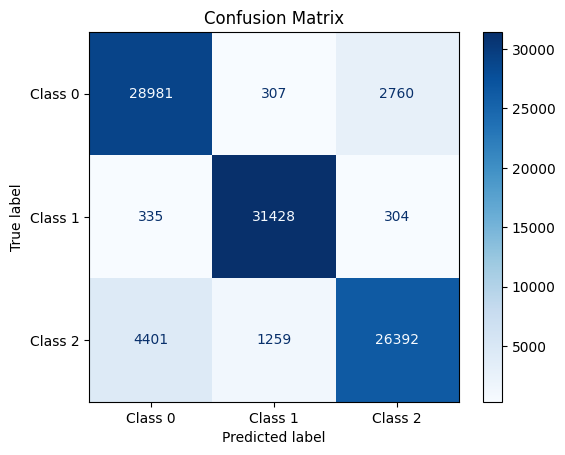

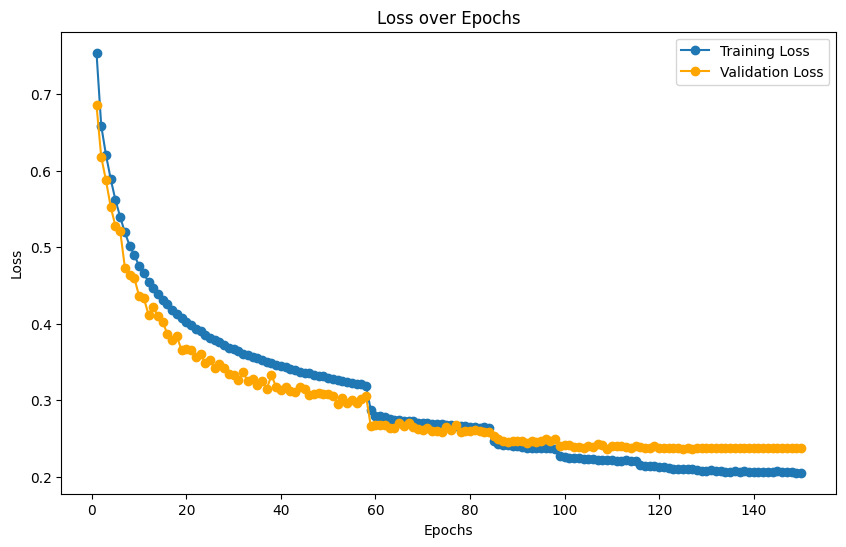

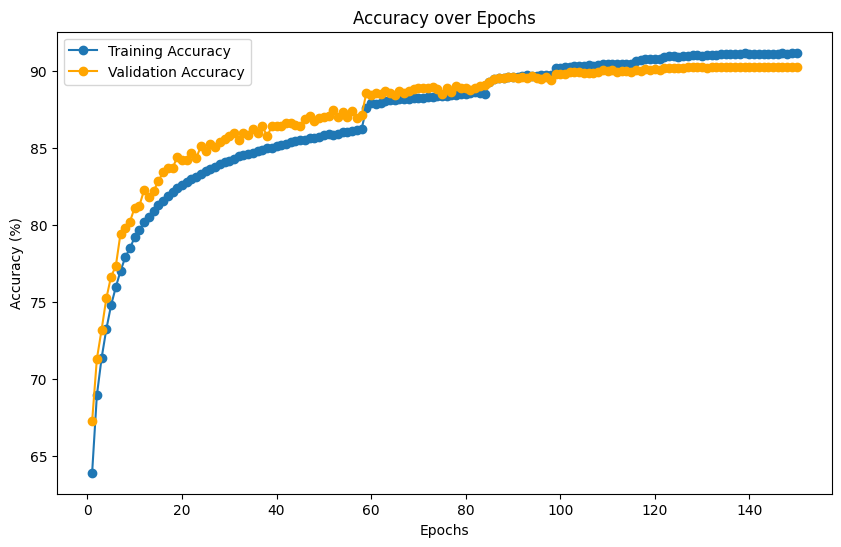

In [ ]:
# Create DataLoader for PyTorch
def create_dataloader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 64
train_loader = create_dataloader(X_train, y_train, batch_size)
val_loader = create_dataloader(X_val, y_val, batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size)

# Step 3: Build the MLP model using PyTorch
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 512)  # Increased neurons
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)  # Reduced dropout to prevent underfitting
        self.output = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.dropout(torch.relu(self.hidden2(x)))
        x = self.dropout(torch.relu(self.hidden3(x)))
        x = self.dropout(torch.relu(self.hidden4(x)))
        x = self.output(x)
        return x

# Calculate class weights
unique_classes, counts = torch.unique(y_resampled, return_counts=True)
class_weights = 1.0 / counts.float()
weights = class_weights[y_resampled]

# Define model, loss function with class weights, optimizer, and scheduler
input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Step 4: Train the model
num_epochs = 150
training_loss = []
validation_loss = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        running_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    avg_loss = running_loss / len(train_loader)
    training_loss.append(avg_loss)

    # Evaluate on validation set
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_y.size(0)
            val_correct += (val_predicted == val_y).sum().item()
            val_running_loss += val_loss.item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    avg_val_loss = val_running_loss / len(val_loader)
    validation_loss.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

# Step 5: Evaluate on test data
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Generate the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2"]))

# Generate and display confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, marker='o', label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
